# MRI reconstruction from multicoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
#from skimage.metrics import structural_similarity as ssim
from common.evaluate import *
from pytorch_msssim import ms_ssim
import pickle
from common.subsample import MaskFunc

from DIP_UNET_models.skip import *

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 2
    torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


In [2]:
def fit_untrained(parnet, num_channels, mask, in_size, slice_ksp, slice_ksp_torchtensor, LR=0.008, num_iter=20000):
    ### fixing the scaling (note that it can be done using the under-sampled kspace as well, but we do it using the full kspace)
    scale_out = 1
    scaling_factor,ni = get_scale_factor(parnet,
                                       num_channels,
                                       in_size,
                                       slice_ksp,
                                       scale_out=scale_out)
    slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
    slice_ksp = slice_ksp * scaling_factor
    ### mask the ksapce
    masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
    unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
    sampled_image2 = transform.ifft2(masked_kspace)
    
    measurement = ksp2measurement(slice_ksp).type(dtype)
    lsimg = lsreconstruction(measurement)
    
    ### fit the network to the under-sampled measurement
    out = []
    for img in sampled_image2:
        out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
    lsest = torch.tensor(np.array([out]))
    scale_out,sover,pover,norm_ratio,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                                num_channels=[num_channels]*(num_layers-1),
                                                                num_iter=num_iter,
                                                                LR=LR,
                                                                mask = mask2d,
                                                                apply_f = forwardm,
                                                                img_noisy_var=unders_measurement,
                                                                net=parnet,
                                                                upsample_mode="free",
                                                                img_clean_var=Variable(lsest).type(dtype),
                                                                #lsimg = lsimg,
                                                                find_best=True,
                                                                loss_type="MSE",
                                                                scale_out=scale_out,
                                                                net_input = ni,
                                                                OPTIMIZER = "adam"
                                                                          )
    return parnet, parni, slice_ksp

In [3]:
def data_consistency(parnet, parni, mask1d, slice_ksp):
    img = parnet(parni.type(dtype))
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
    # ksp has dim: (num_slices,x,y)
    meas = ksp2measurement(slice_ksp) # dim: (1,num_slices,x,y,2)
    mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
    ksp_dc = Fimg.clone()
    ksp_dc = ksp_dc.detach().cpu()
    ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

    img_dc = transform.ifft2(ksp_dc)[0]
    out = []
    for img in img_dc.detach().cpu():
        out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]

    par_out_chs = np.array(out)
    #par_out_chs = parnet( parni.type(dtype),scale_out=scale_out ).data.cpu().numpy()[0]
    par_out_imgs = channels2imgs(par_out_chs)

    prec = crop_center2(root_sum_of_squares2(par_out_imgs),320,320)
    return prec

# Loading MRI measurement

Kspace shape (number slices, number coils, x, y):  (33, 15, 640, 368)


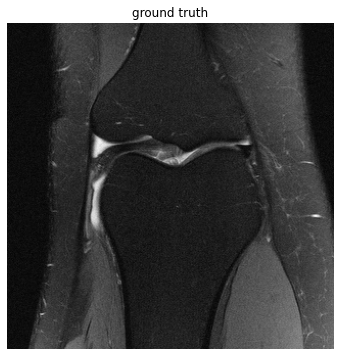

In [4]:
### Get image from the validation set
filename = '/hdd/multicoil_val/file1001191.h5' # with fat suppression
#filename = '/hdd/multicoil_val/file1000126.h5' # without fat suppression


f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu = f["kspace"].shape[0]//2
slice_ksp = f['kspace'][slicenu]
slice_ksp_torchtensor = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(f["reconstruction_rss"][slicenu],"gray")
ax.set(title="ground truth")
ax.axis("off")
plt.show()

In [5]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 4 # desired under-sampling factor
    undersampling_factor = 0
    tolerance = 0.03
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()
print("under-sampling factor:",round(len(mask1d)/sum(mask1d),2))

under-sampling factor: 4.72


### Setup and fit ConvDecoder

In [6]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]

In [7]:
arch_name = "ConvDecoder"
###
num_channels = 160 #256
num_layers = 8
strides = [1]*(num_layers-1)
in_size = [8,4]
kernel_size = 3
net = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=False, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype)
print("#prameters of {}:".format(arch_name),num_param(net))
#print(net)

[(15, 8), (28, 15), (53, 28), (98, 53), (183, 102), (343, 193), (640, 368)]
#prameters of ConvDecoder: 1850560


In [8]:
net,ni,slice_ksp_cd = fit_untrained(net, num_channels, mask, in_size, slice_ksp, slice_ksp_torchtensor)

input provided
optimize with adam 0.008


In [9]:
rec_convD = data_consistency(net, ni, mask1d, slice_ksp_cd)

### Setup and fit Deep Decoder (DD)

In [10]:
### delete cashe
del(net,ni)
torch.cuda.empty_cache()

In [11]:
arch_name = "DD"
###
num_channels = 368
num_layers = 10
in_size = [16,16]

net = skipdecoder(out_size,in_size,output_depth,
                   num_layers,num_channels,skips=False,need_last=True,
                   need_sigmoid=False,upsample_mode="bilinear").type(dtype)
print("#prameters of {}:".format(arch_name),num_param(net))
#print(net)

[(25, 23), (37, 33), (55, 46), (83, 65), (125, 92), (188, 130), (282, 184), (425, 260), (640, 368)]
#prameters of DD: 1372640


In [12]:
net,ni,slice_ksp_cd = fit_untrained(net, num_channels, mask, in_size, slice_ksp, slice_ksp_torchtensor)

input provided
optimize with adam 0.008


In [13]:
rec_DD = data_consistency(net, ni, mask1d, slice_ksp_cd)

### Setup and fit Deep Image Prior (DIP) (encoder-decoder style architecture)

In [14]:
### delete cashe
del(net,ni)
torch.cuda.empty_cache()

In [15]:
arch_name = "DIP"
### 
in_size = slice_ksp.shape[-2:]
pad = "zero" #'reflection' # 'zero'
num_channels = 256
net = skip(in_size,num_channels, output_depth, 
           num_channels_down = [num_channels] * 8,
           num_channels_up =   [num_channels] * 8,
           num_channels_skip =    [num_channels*0] * 6 + [4,4],  
           filter_size_up = 3, filter_size_down = 5, 
           upsample_mode='nearest', filter_skip_size=1,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='ReLU').type(dtype)
print("#prameters of {}:".format(arch_name),num_param(net))
#print(net)

#prameters of DIP: 31514182


In [16]:
net,ni,slice_ksp_cd = fit_untrained(net, num_channels, mask, in_size, slice_ksp, slice_ksp_torchtensor)

input provided
optimize with adam 0.008


In [17]:
rec_DIP = data_consistency(net, ni, mask1d, slice_ksp_cd)

### Evaluation

In [18]:
def scores(im1,im2):
    im1 = (im1-im1.mean()) / im1.std()
    im1 *= im2.std()
    im1 += im2.mean()
    
    vif_ = vifp_mscale(im1,im2,sigma_nsq=im1.mean())
    
    ssim_ = ssim(np.array([im1]), np.array([im2]))
    psnr_ = psnr(np.array([im1]),np.array([im2]))

    dt = torch.FloatTensor
    im11 = torch.from_numpy(np.array([[im1]])).type(dt)
    im22 = torch.from_numpy(np.array([[im2]])).type(dt)
    ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]
    return vif_, ms_ssim_, ssim_, psnr_

In [19]:
gt = f["reconstruction_rss"][slicenu]

In [20]:
vif_cd, ms_ssim_cd, ssim_cd, psnr_cd  = scores(gt, rec_convD)
vif_dd, ms_ssim_dd, ssim_dd, psnr_dd  = scores(gt, rec_DD)
vif_dip, ms_ssim_dip, ssim_dip, psnr_dip  = scores(gt, rec_DIP)

### Visualization

ConvDecoder       --> VIF: 0.63, MS-SSIM: 0.94, SSIM: 0.75, PSNR: 31.62 
Deep Decoder      --> VIF: 0.62, MS-SSIM: 0.86, SSIM: 0.67, PSNR: 29.14 
Deep Image Prior  --> VIF: 0.54, MS-SSIM: 0.88, SSIM: 0.42, PSNR: 25.99 


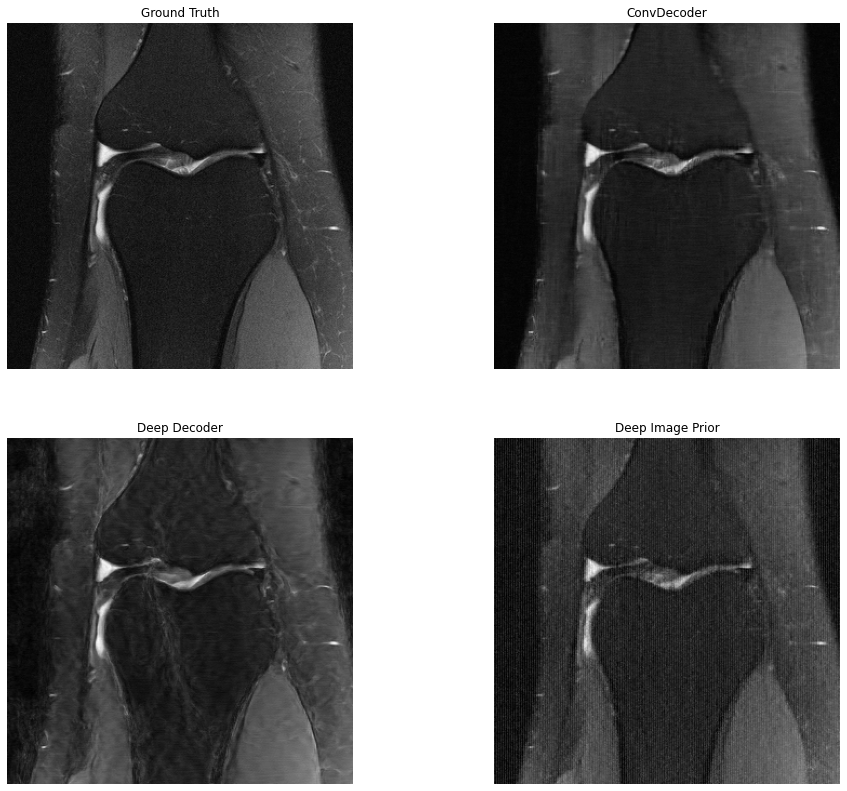

In [21]:
fig = plt.figure(figsize = (16,14)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(221)
ax1.imshow(gt,cmap='gray')
ax1.set_title('Ground Truth')
ax1.axis('off')

ax2 = fig.add_subplot(222)
ax2.imshow(rec_convD,cmap='gray')
ax2.set_title( "ConvDecoder") 
ax2.axis('off') 

ax3 = fig.add_subplot(223)
ax3.imshow(rec_DD,cmap='gray')
ax3.set_title( "Deep Decoder" ) 
ax3.axis('off')

ax4 = fig.add_subplot(224)
ax4.imshow(rec_DIP,cmap='gray')
ax4.set_title( "Deep Image Prior" ) 
ax4.axis('off')

print("ConvDecoder       --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_cd,ms_ssim_cd,ssim_cd,psnr_cd))
print("Deep Decoder      --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_dd,ms_ssim_dd,ssim_dd,psnr_dd))
print("Deep Image Prior  --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_dip,ms_ssim_dip,ssim_dip,psnr_dip))

plt.show()